In [1]:
import librosa
import librosa.display
import IPython.display

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### librosa로 wav 파일 불러오기

In [19]:
y,sr=librosa.load(r'C:\Users\Affinity\Documents\Audacity\ai 더빙 테스트\500.wav')

### IPython으로 재생

In [5]:
IPython.display.Audio(data=y,rate=sr)

### y랑 sr값 확인

In [6]:
y

array([ 7.78899266e-05,  1.43822253e-04,  1.17864096e-04, ...,
        1.90860359e-03,  2.38692388e-03, -5.95575722e-04], dtype=float32)

In [7]:
sr

22050

### matplotlib으로 파형 확인해본다


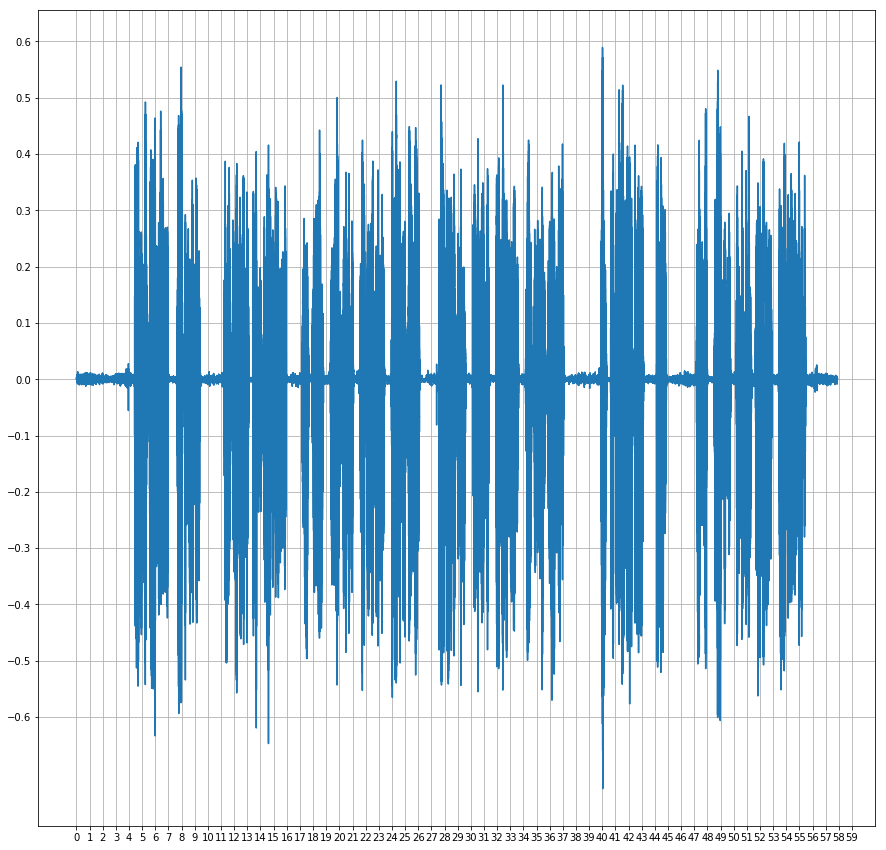

In [12]:
time=np.linspace(0,len(y)/sr,len(y))     

#np.linspace(a,b,c)  = a~b를 c간격으로 쪼갠다 이렇게하면 y랑 time이랑 1대1로 매핑되고 시간을 초단위로 볼수있음
#len(y)/sr=58.xxx 초정도됌

plt.figure(figsize=(15,15))
plt.plot(time,y)
plt.grid(True)
plt.xticks(range(0,60))
plt.yticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6])
plt.show()

 파형을보니꺼 y값(세로축)을 묵음인 부분은 0.05밑으로 잡으면 될거같다.
 
그리고 문장간 간격이 3초라고 들었는데, 그거보단 짧은거같다. 

0.8초~1초정도면 문장간 분류가 가능할거같다.

첫번째문장, 두번째문장이 텀이 너무짧아서 분류가 어렵다.

(이샘플은 8문장 - 58초 짜리 샘플이다)


(실제로 분류한건 500문장 1시간짜리파일)

### 함수로 만들기

In [21]:
point=[]  #한문장이 끝나는 지점 , 이지점을 기준으로 잘라줄 예정이다.
point_0=[]
def silence_slice(y,sr=22050,seconds=1,limit=0.05):
    #address: 파일이 있는 주소
    #seconds: 침묵이 몇초 지속되면 한문장이 끝난걸로 볼것인가?
    #limit: 음파 높이가 몇 이하인 놈들을 침묵으로 볼것인가?
    
    #y,sr=librosa.load(address)  #y=데시벨? 같은느낌 음파높이,  sr=rate

    index_list=[]   
    #silence가 지속되는 동안 계속여기에 값들을 append 해준다. 
    #len(index_list)가 몇초 이상지나면 한문장이 끝난걸로 볼수있다.   

    #point=[]  #한문장이 끝나는 지점 , 이지점을 기준으로 잘라줄 예정이다.
    #point_0=[]
    y_df=pd.DataFrame(y,columns=['y']) # y를 데이터프레임화
    
    
    silence=y_df.loc[abs(y_df.y)<limit]   # 파고가 limit미만인 애들을 silence라고 정의하고 이놈들만 추려준다.

    for i in range(len(silence.index)-1):
       
        index_list.append(silence.index[i])  
        if (silence.index[i]+1) != (silence.index[i+1]):   #만약 인덱스가 연속적이지 않다면(소리가 발생했다면)
            if len(index_list)/sr>seconds:                 #index_list 길이를 확인해서 seconds가 넘는다면,
                point.append(silence.index[i])             #그동안 유지된 silence는 문장사이의 침묵으로 보고 그부분에서 잘라준다.(point에 추가)           
                point_0.append(index_list[0])
                index_list=[]
            else:
                index_list=[]
                
    for k in range(len(point)-1):
        if np.mean(abs(y[point[k]:point[k+1]]))<0.355:   #내가 feature를 찾아서 스크립트 넘기는소리를 검출하기위한 조건문을 짰다.
            if np.max(abs(y[point[k]:point[k+1]]))<0.3:  #스크립트넘기는 소리는 평균이 얼추 0.35 밑이고 맥스값이 0.3? 아래?
                name='D:/new_test/trash_list/cutfile{}.wav'.format(k)
                librosa.output.write_wav(name,y[point[k]:point_0[k+1]],sr)
                continue     
                   
        
        name='D:/new_test/cutfile{}.wav'.format(k)
        
        librosa.output.write_wav(name,y[point[k]:point[k+1]],sr)  #포인트 사이를 잘라서 저장해줌
   
    
    # 첫문장 
    name='D:/new_test/cutfile{}.wav'.format("00")
    librosa.output.write_wav(name,y[:point_0[0]]+sr/2,sr) #처음~첫포인트 
    
    
    #마지막문장을 뽑아주기 위한 작업
    name='D:/new_test/cutfile{}.wav'.format(len(point)-1)
    librosa.output.write_wav(name,y[point[-1]:-1],sr) #마지막포인트 지점~ 끝까지 

### 테스트

In [20]:

address='C:/Users/Affinity/Documents/Audacity/ai 더빙 테스트/500.wav'
point=[]  #한문장이 끝나는 지점 , 이지점을 기준으로 잘라줄 예정이다.
point_0=[]
silence_slice(y,sr,seconds=1.3,limit=0.15)  #0.7로 하니까 이쁘게 잘나옴

In [ ]:
y,sr=librosa.load(r'E:/ai/silence cut/cutfile7.wav')
IPython.display.Audio(data=y,rate=sr)

### 결과


500문장-504분할

589문장-589분할

수치상으로 보면 엄청 정확해 보이나

두문장이 한문장으로 읽힌경우와 한문장이 두문장으로 읽힌경우가 상쇄되서

수치상으로 정확해 보이는것이다.

전부 세어보진않았으나 

틀린 총갯수는 10개? 정도 될것같다.

이정도면 꽤 정확하다고 생각된다.

이오류중에는 녹음상 이유로 불가피한 오류도 있다고 생각된다.

문장과 문장 사이 텀이 1초가 안되는데 한문장 안에서 1초이상을 쉬어버린경우,

이런경우는 거의 잡기 힘들다.

녹음이 좀만더 클리어하면 정확도도 더 좋아질것 같다.

### 고찰

잘못잘리는경우가
1. 스크립트 넘기는소리

2. 기침소리

3. 두문장이 한문장으로 읽히는경우

4. 한문장이 쉬어읽기에서 두문장으로 잘리는경우

이렇게 나눌수있다.

스크립트소리는 max값과 mean값으로 거의 잡을수 있었다
(mean<0.355, max<0.3 이렇게 설정하면 스크립트소리는 거의다 잡혔다)

기침소리는 파형이 문장과 거의 비슷해서 못잡았다.

두문장->한문장 문제와 한문장->두문장 문제는 trade off 관계에 있다고 생각된다.
파라미터중 seconds를 길게하면 한문장->두문장 문제는 줄어드나 
두문장->한문장 문제가 더커진다. 이중간점을 잘잡아야된다.
그런데 나중에 다시 수정할걸 생각하면 seconds를 살짝 길게하는게
유리할 것 같다. 한문장을 자르는게 두문장을 이어붙이는것보다 손이 덜갔던것같다.



### 시간이 충분하다면

* 기침소리를 어떻게 잡을지 생각해봤는데
기침데이터가 충분하다면 기침=1, 문장=0 이런식으로 라벨링해놓고 
머신러닝으로 학습을 시킬수도 있을것같다.
근데 기침은 500문장에 1,2개 있을까 말까한 빈도라서
학습도 못시키고, 그냥 듣고 삭제해주는게 가장 현명할것같다.



*그리고 3,4번 문제같은경우, 스크립트 와 음성파일의 길이를 1대1로 매핑할수있을것이다.
그걸로 linear regression 을 돌려보면 '몇글자일땐 음성이 몇초다' 라는걸 대략적으로 구할수있다.
이걸로 for문 돌려서 글자수랑 음성길이랑 안맞으면 바로잘라서 저장하는 코드를 짜면될것같다.



(sudo)
    
    

for i,j in (텍스트 list,음성 list):

    if len(i)>len(j):  (텍스트가 더 긴경우: 한문장인데, 둘로잘린경우)

        run(다음음성이랑 현재 음성이랑 합치는 함수)
        
        j++
        
    if len(i)<len(j):   (음성이 더 긴경우:두음성이 하나로 합쳐진 경우)
        
        run(현재음성을 둘로 자르는 함수)
        
        i++

